In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to train a CNN model

In [2]:
import warnings
import gc
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Load Data

In [3]:
# load data using joblib
X_train = joblib.load("data/transformed/X_train.pkl")
X_val = joblib.load("data/transformed/X_val.pkl")
X_test = joblib.load("data/transformed/X_test.pkl")

y_train = joblib.load("data/transformed/y_train.pkl")
y_val = joblib.load("data/transformed/y_val.pkl")
y_test = joblib.load("data/transformed/y_test.pkl")

print(f'{X_train.shape=}')
print(f'{y_train.shape=}')
print(f'{X_test.shape=}')
print(f'{y_test.shape=}')

X_train.shape=(31225, 80, 3)
y_train.shape=(31225,)
X_test.shape=(13181, 80, 3)
y_test.shape=(13181,)


# Hyper-parameter Tuning

In [4]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(np.unique(y_train))

In [5]:
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes accuracy on the validation set.'''
    clear_session()

    # define early stopping
    early_stop = EarlyStopping(monitor='val_loss',patience=10)

    model = Sequential()

    model.add(Conv1D(filters=trial.suggest_categorical("filters", [128, 128*2, 128*3, 128*4, 128*5]), kernel_size=3, activation='relu', input_shape=(timesteps,n_features)))

    model.add(Conv1D(filters=trial.suggest_categorical("filters", [128, 128*2, 128*3, 128*4, 128*5]), kernel_size=3, activation='relu'))

    model.add(Dropout(trial.suggest_uniform("dropout", 0.0, 0.5)))

    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(units=trial.suggest_categorical("units", [128, 128*2, 128*3, 128*4, 128*5]), activation='relu'))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy'])

    # fit model
    model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[early_stop],
        verbose=False,
    )

    # compute validation error
    score = model.evaluate(X_val, y_val, verbose=0)
    
    return score[1]

In [6]:
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction="maximize", study_name="CNN")
study.optimize(objective, n_trials=5)

[I 2023-04-06 23:10:58,664] A new study created in memory with name: CNN


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-06 23:10:58.860252: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[I 2023-04-06 23:22:13,336] Trial 0 finished with value: 0.738601803779602 and parameters: {'filters': 512, 'dropout': 0.1861461504414904, 'units': 640, 'batch_size': 64}. Best is trial 0 with value: 0.738601803779602.
[I 2023-04-06 23:26:40,398] Trial 1 finished with value: 0.40395137667655945 and parameters: {'filters': 512, 'dropout': 0.3331751795695772, 'units': 128, 'batch_size': 32}. Best is trial 0 with value: 0.738601803779602.
[I 2023-04-06 23:30:30,302] Trial 2 finished with value: 0.7082067131996155 and parameters: {'filters': 256, 'dropout': 0.4652296964776312, 'units': 512, 'batch_size': 64}. Best is trial 0 with value: 0.738601803779602.
[I 2023-04-06 23:32:24,966] Trial 3 finished with value: 0.7150962352752686 and parameters: {'filters': 128, 'dropout': 0.2941338419858382, 'units': 256, 'batch_size': 128}. Best is trial 0 with value: 0.738601803779602

In [7]:
# print best parameters
best_params = study.best_trial.params
print(f'{best_params=}')

best_params={'filters': 512, 'dropout': 0.1861461504414904, 'units': 640, 'batch_size': 64}


# Fit model with best parameters

In [8]:
dropout = best_params['dropout']
filters = best_params['filters']
units = best_params['units']

In [9]:
clear_session()
# define early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

# define model architecture
best_model = Sequential()

best_model.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=(timesteps,n_features)))

best_model.add(Conv1D(filters=filters, kernel_size=3, activation='relu'))

best_model.add(Dropout(dropout))

best_model.add(MaxPooling1D(pool_size=2))

best_model.add(Flatten())

best_model.add(Dense(units=units, activation='relu'))

best_model.add(Dense(n_classes, activation='softmax'))

best_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy'])
    
# fit model
best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stop],
    verbose=False,
)

In [10]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 512)           5120      
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 512)           786944    
                                                                 
 dropout (Dropout)           (None, 76, 512)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 512)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 19456)             0         
                                                                 
 dense (Dense)               (None, 640)               12452480  
                                                        

<Axes: >

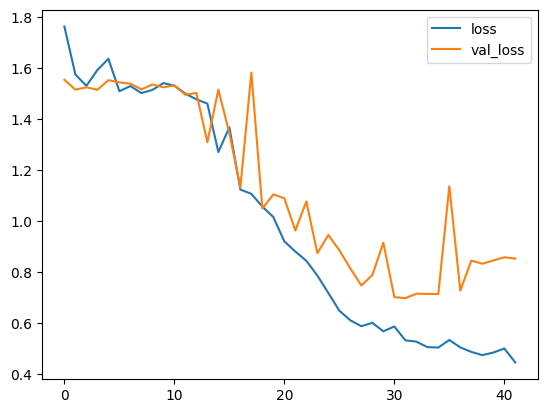

In [11]:
losses = pd.DataFrame(best_model.history.history)
losses[['loss', 'val_loss']].plot()

<Axes: >

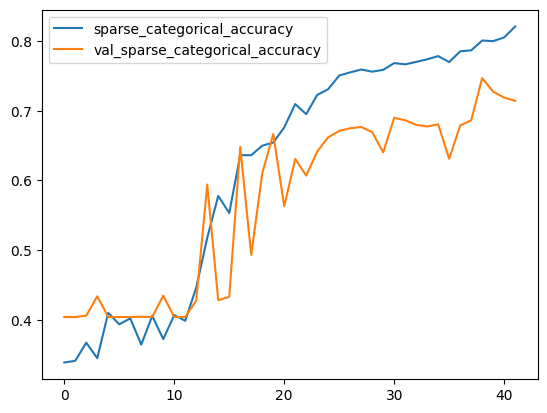

In [12]:
accuracy = pd.DataFrame(best_model.history.history)
accuracy[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [13]:
# Evaluate the model accuracy on the test set.
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.7198227047920227 / Test accuracy: 0.7651923298835754


# Save Predictions & model

In [14]:
# save the model using joblib
joblib.dump(best_model, "models/cnn_model.pkl")

INFO:tensorflow:Assets written to: ram://ff4daf1a-14a1-41ed-b413-dc359bcf9dc9/assets


INFO:tensorflow:Assets written to: ram://ff4daf1a-14a1-41ed-b413-dc359bcf9dc9/assets


['models/cnn_model.pkl']

In [15]:
# save predictions
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred = pd.DataFrame(y_pred, columns=["predicted_activity"])
y_pred.to_csv("predictions/predictions_cnn.csv", index=False)

412/412 [==============================] - 2s 6ms/step


In [16]:
# https://link.springer.com/article/10.1007/s11370-021-00358-7 (CNN + LSTM)
# https://ieeexplore.ieee.org/document/7881728 (CNN)
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/ (CNN)
# https://medium.com/@tanmaychauhan111/human-activity-recognition-using-lstm-cnn-8ccb1a42cb81
# user mcnemars test to compare models